In [1]:
# import all required modules 
import pyvisa
import visa
import logging
import sys
import time
import json
import wavedrom
from quantiphy import Quantity as QE
import matplotlib.pyplot as plt
from datetime import datetime
import rigol1000z as Rigol1000z
from IPython.display import Image
from matplotlib.ticker import EngFormatter

In [2]:
# ========== Configuration Section ==========
# Change this to to correct connection strings
conn_str = 'GPIB0::17::INSTR'
rigol_Conn_Str = "USB0::0x1AB1::0x04CE::DS1ZB165251691::INSTR"
# DFF Pins to SMU Channel Mapping 
clk_pin = 2
vdd_pin = 3
d_pin = 4
q_ff = 5
vdd_v = 1.2

# Some other intermidiate Variables
formatter1 = EngFormatter(places=2, sep="")
SimulationTime = -1

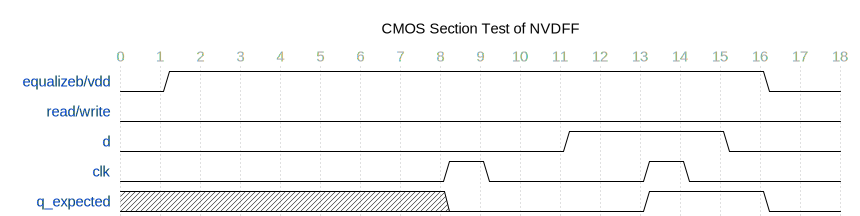

In [3]:
# ======== Waveform Generator ========
# The test waveform is generated using following JSON from wavedrom project
# Changes in following JSON also changes the waveform
# In this setup only VDD and Equilizeb pins are shorted
# Read/Write is directly connected to the gnd 
# SMU 1 is connected to the CLK pin
# SMU 2 is connected to VDD+Equib pin
# SMU 3 is connected to D input of FF
# SMU 4 configured as a VOLTMETER to read FF output voltage transition 
tick_time = QE('50ns')
waveform_json = """
{"signal": [
 {"name": "equalizeb/vdd", "wave": "01..............0."},
 {"name": "read/write", "wave": "0................."},
 {"name": "d", "wave": "0..........1...0.."},
 {"name": "clk", "wave": "0.......10...10..."},
 {"name": "q_expected", "wave": "x.......0....1..0."}
],
 "head":{
 "text":"CMOS Section Test of NVDFF",
 "tick":0
}}
"""
wavedrom.render(waveform_json)

In [4]:
waveform = {}
for each in json.loads(waveform_json)["signal"]:
    waveform[each["name"]] = each["wave"]

In [5]:
def parse_wave_seq(seq, tick):
    if set(seq).difference({'.', '0', '1'}):
        raise Exception("Invalid charater in sequence")
        return
    if tick> len(seq):
        raise Exception("Tick is out of sequence")
        return 
    while(seq[tick] == "."):
        tick = tick-1 
        pass
    return float(seq[tick])

In [6]:
SimulationTime = len(waveform[list(waveform.keys())[0]]) if SimulationTime == -1 else SimulationTime
print(f"Simulating for {SimulationTime} Ticks")

Simulating for 18 Ticks


In [7]:
# Setting up PyVISA interface
rm = pyvisa.ResourceManager()
dev_list = rm.list_resources()
if conn_str not in dev_list:
    logger.error(f"Device {conn_str} not found")
    exit(1)
    
# Setting up B1500 
B1500A = rm.open_resource(conn_str)
device_name = B1500A.query("*IDN?")
B1500A.write("*RST")  # Reset B1500 to initial state
B1500A.write("FMT 1")  # Set IO Format
print(f"Connected to {device_name}")

# Clear All the channels to simulate
B1500A.write(f"CL {clk_pin},{vdd_pin},{d_pin},{q_ff}")
B1500A.write(f"CN {clk_pin},{vdd_pin},{d_pin},{q_ff}")  

Connected to Agilent Technologies,B1500A,0,A.06.01.2016.0401



(12, <StatusCode.success: 0>)

In [8]:
def screenshot(file_suff):
    rm = visa.ResourceManager()
    res = rm.list_resources()
    #print( res )
    ins = rm.get_instrument( res[0] ) # !

    ins.write(":DISP:DATA?")
    bmpdata = ins.read_raw()[2+9:]

    ins.close()

    # save image file
    name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    print("Enter a filename-safe description (or none). Hit return.")
    comment = file_suff
    if( len(comment) ):
        name = comment

    try:
        from PIL import Image

    except ImportError as e:
        print("PIL(low) not imported because:", e)
        filename = name + ".png"
        print("Saving screen as", filename)
        with open( filename, "wb") as f:
            f.write( bmpdata )
    return filename

In [9]:
# Setting Up RIGOl 1074 Oscilloscope
osc_resource = rm.open_resource(rm.list_resources()[0])
osc = Rigol1000z.Rigol1000z(osc_resource)
osc.timebase.set_timebase_scale_s_div(50E-3)
osc.trigger.set_trigger_level_V(0.5)
for i in 1,2,3:
    osc[i].set_vertical_scale_V(1)
    osc[i].set_probe_ratio(1)
    osc[i].visa_write(':disp 1')
    osc.visa_write(":chan%d:OFFSet %.2f"%(i,(i*2)-5))

In [19]:
# Check connectivity of pins
for eachPin in [clk_pin,d_pin]:
    B1500A.write(f"CL {clk_pin},{vdd_pin},{d_pin},{q_ff}")
    B1500A.write(f"CN {clk_pin},{vdd_pin},{d_pin},{q_ff}")
    
    comp_curr = 10E-6
    B1500A.write(f"DV {vdd_pin},0,0,{comp_curr}")
    B1500A.write(f"DV {vdd_pin},0,0,{comp_curr}")
    B1500A.write(f"DV {d_pin},0,0,{comp_curr}")
    
    force_current = -1E-6
    B1500A.write(f"DI {eachPin},0,{force_current},2")
    Q_Out =  B1500A.query(f"TV {eachPin}")
    print(" Voltage ", QE(Q_Out[3:],"V"), "Passed" if -1.5 < float(Q_Out[3:]) < -0.2 else "Failed")

 Voltage  -650.9 mV Passed
 Voltage  -422.1 mV Passed


## This part checks the VDD Current of the chip

VDD Current  100.01 uA
FlipFlop Out Voltage  25.2 mV
Enter a filename-safe description (or none). Hit return.
PIL(low) not imported because: No module named 'PIL'
Saving screen as 2019-10-28_16-49-32_VDD_PUlSE.png


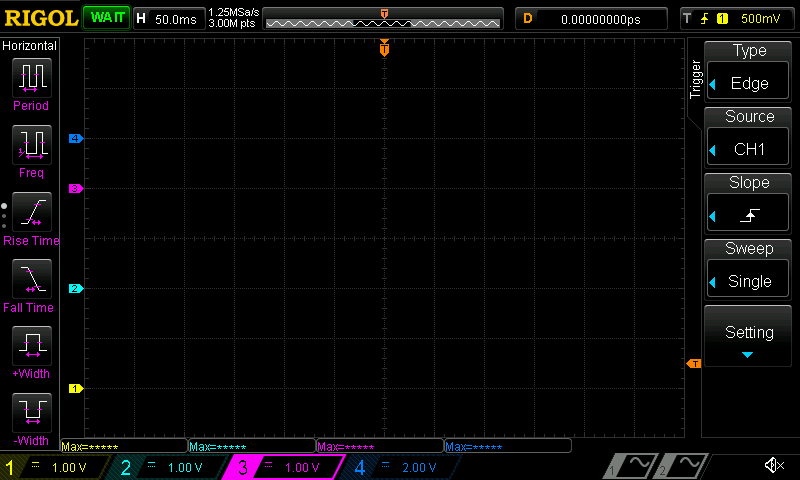

In [20]:
# Clear All the channels to simulate
B1500A.write(f"CL {clk_pin},{vdd_pin},{d_pin},{q_ff}")
B1500A.write(f"CN {clk_pin},{vdd_pin},{d_pin},{q_ff}")

osc.set_single_shot()
osc.timebase.set_timebase_scale_s_div(50E-3)
time.sleep(1)

# Set q_ff channel as a Voltmeter 0 to 1.8
B1500A.write(f"DI {q_ff},0,0,1.8")

# Set Other Pins to 0
comp_curr = 1E-6
B1500A.write("DV %d,0,%.2f,%.2E"% (clk_pin, 0,comp_curr))
B1500A.write("DV %d,0,%.2f,%.2E"% (d_pin, 0,comp_curr))

# Pulse on VDD and Measure IVDD Current
comp_curr = 100E-6
B1500A.write("DV %d,0,%.2f,%.2E"% (vdd_pin, 1.2, comp_curr))
time.sleep(0.2)
res = B1500A.query(f"TI {vdd_pin}")
Q_Out =  B1500A.query(f"TV {q_ff}")
B1500A.write("DV %d,0,%.2f"% (vdd_pin, 0))

print("VDD Current ",QE(res[4:],"A"))
print("FlipFlop Out Voltage ", QE(Q_Out[4:],"V"))

time.sleep(1)
Image(filename=screenshot("VDD_PUlSE")) 

## NVFF CMOS Part Simulation

c:\users\lnis\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Enter a filename-safe description (or none). Hit return.
PIL(low) not imported because: No module named 'PIL'
Saving screen as 2019-10-28_17-02-36_SaveTest23.png


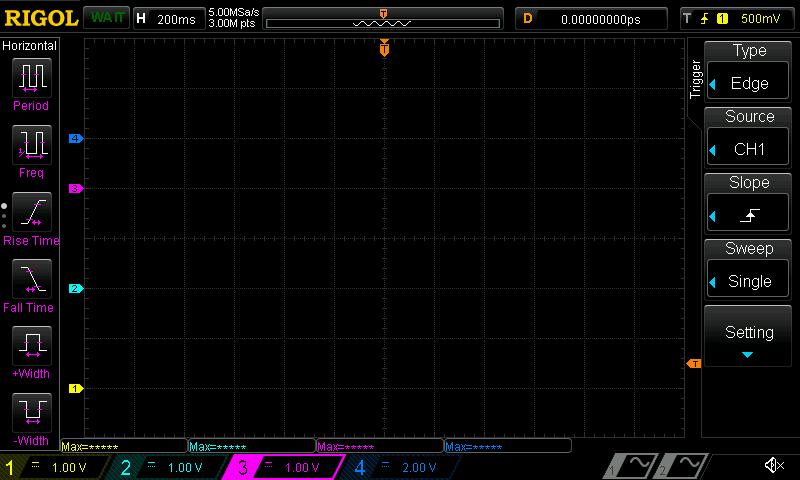

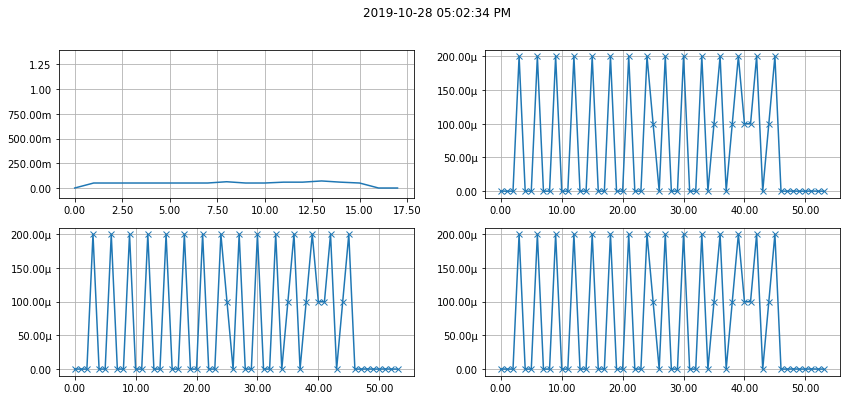

In [21]:
# Clear All the channels to simulate Final DFF Output
B1500A.write(f"CL {clk_pin},{vdd_pin},{d_pin},{q_ff}")
B1500A.write(f"CN {clk_pin},{vdd_pin},{d_pin},{q_ff}")   

osc.set_single_shot()
osc.timebase.set_timebase_scale_s_div(0.2)
time.sleep(3)

# Set q_ff channel as a Voltmeter
B1500A.write(f"DI {q_ff},0,0,2")
q_ff_v = []
clk_curr = d_curr = vdd_curr = []

comp_current = 100E-6
for i in range(SimulationTime):
    B1500A.write("DV %d,0,%.2f,%.2E"% (clk_pin, vdd_v*parse_wave_seq(waveform["clk"], i), comp_current))
    B1500A.write("DV %d,0,%.2f,%.2E"% (vdd_pin, vdd_v*parse_wave_seq(waveform["equalizeb/vdd"], i), 2*comp_current))
    B1500A.write("DV %d,0,%.2f,%.2E"% (d_pin, vdd_v*parse_wave_seq(waveform["d"], i), comp_current))
    Q_Out =  B1500A.query(f"TV {q_ff}")
    q_ff_v.append(QE(Q_Out[4:],"V"))
    vdd_curr.append(float(B1500A.query(f"TI {vdd_pin}")[4:]))
    clk_curr.append(float(B1500A.query(f"TI {clk_pin}")[4:]))
    d_curr.append(float(B1500A.query(f"TI {d_pin}")[4:]))

# This disconnects all the SMU channels and keeps probes floating
# Recommended condition in IDLE state of the instrument
B1500A.write(f"CL {clk_pin},{vdd_pin},{d_pin},{q_ff}")

fig = plt.figure(figsize=(14,6))
fig.suptitle(datetime.now().strftime('%Y-%m-%d %I:%M:%S %p'))

plt.subplot(2,2,1)
plt.ylim([-0.1,1.4])
plt.plot([float(qq) for qq in q_ff_v])

plt.subplot(2,2,2)
plt.plot(vdd_curr, marker="x")

plt.subplot(2,2,3)
plt.plot(clk_curr, marker="x")

plt.subplot(2,2,4)
plt.plot(d_curr, marker="x")

for i in range(4):
    myplt = plt.subplot(2,2,i+1)
    myplt.grid()
    myplt.xaxis.set_major_formatter(formatter1)
    myplt.yaxis.set_major_formatter(formatter1)
time.sleep(1)
Image(filename=screenshot("SaveTest23")) 